In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [14]:
# !unzip 'archive.zip' -d 'MIT-671'

Archive:  archive.zip
  inflating: MIT-671/TestImages.txt  
  inflating: MIT-671/TrainImages.txt  
  inflating: MIT-671/indoorCVPR_09/Images/airport_inside/airport_inside_0001.jpg  
  inflating: MIT-671/indoorCVPR_09/Images/airport_inside/airport_inside_0002.jpg  
  inflating: MIT-671/indoorCVPR_09/Images/airport_inside/airport_inside_0003.jpg  
  inflating: MIT-671/indoorCVPR_09/Images/airport_inside/airport_inside_0004.jpg  
  inflating: MIT-671/indoorCVPR_09/Images/airport_inside/airport_inside_0005.jpg  
  inflating: MIT-671/indoorCVPR_09/Images/airport_inside/airport_inside_0006.jpg  
  inflating: MIT-671/indoorCVPR_09/Images/airport_inside/airport_inside_0007.jpg  
  inflating: MIT-671/indoorCVPR_09/Images/airport_inside/airport_inside_0008.jpg  
  inflating: MIT-671/indoorCVPR_09/Images/airport_inside/airport_inside_0009.jpg  
  inflating: MIT-671/indoorCVPR_09/Images/airport_inside/airport_inside_0010.jpg  
  inflating: MIT-671/indoorCVPR_09/Images/airport_inside/airport_inside

In [9]:
!git clone https://github.com/Stanpie3/importance_sampling.git
!mv importance_sampling/* .
!rm -r importance_sampling

Cloning into 'importance_sampling'...


In [47]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [48]:
from src.train_importance_sampling import VarReductionCondition, get_g
from src.utils.common import Accumulator

def train_batch_is(model,
                x_batch,
                y_batch,
                loss_fn,
                optimizer,
                accumulator : Accumulator,
                condition : VarReductionCondition,
                presample = 3.0,
                use_loss_estimation = False,
                second_approach = False):

    flag = False
    model.train()
    model.zero_grad()

    batch_size = x_batch.shape[0]

    selected_batch_size = int(batch_size / presample)

    if condition.satisfied :
        if second_approach:
            with torch.no_grad(): output = model(x_batch)
        #print("condition satisfied")
        else:
            output = model(x_batch)
            
        g_i_norm = get_g(output, y_batch, loss_fn, use_loss_estimation  )
        condition.update(g_i_norm)
        flag = True
    else:
        #print("condition not satisfied")
        g_i_norm = np.ones(batch_size)


    p_i = g_i_norm / np.sum(g_i_norm)
    batch_indices = np.random.choice(np.arange(batch_size), size = selected_batch_size, replace=True, p=p_i)

    selected_p_i = p_i[batch_indices]

    if condition.previously_satisfied:
        #if
        if second_approach:
            output = model(x_batch[batch_indices])
            y_batch = y_batch[batch_indices]
            loss = loss_fn(output, y_batch)
            selected_loss = loss
            loss = loss_fn(output, y_batch)
        else:
            loss = loss_fn(output, y_batch)
            selected_loss = loss[batch_indices]
    else :
        output = model(x_batch[batch_indices])
        y_batch = y_batch[batch_indices]
        condition.update( get_g(output, y_batch, loss_fn, use_loss_estimation ) )
        loss = loss_fn(output, y_batch)
        selected_loss = loss

    w_i = 1.0 / (batch_size * selected_p_i)

    weighted_loss = (torch.tensor(w_i).to(selected_loss.device).detach() * selected_loss).mean()

    weighted_loss.backward()

    optimizer.step()

    max_p_i = np.max(p_i)
    num_unique_points = np.unique(batch_indices).size


    n = len(output)
    with torch.no_grad():
        batch_loss = loss.mean().cpu().item()
        weighted_batch_loss = weighted_loss.mean().cpu().item()
        batch_acc_sum = (output.argmax(dim=1) == y_batch).sum().cpu().item()/n


    accumulator.average(
        train_loss = ( batch_loss, n) ,
        train_acc = ( batch_acc_sum, n) ,
        train_w_loss = ( weighted_batch_loss, selected_batch_size) ,
        train_uniform_cnt = flag)

    accumulator.store(
        max_p_i = max_p_i ,
        num_unique_points = num_unique_points)


In [55]:
def train_full(model, train_dataloader, loss_fn, optimizer, n_epochs, eval = None, callback=None, presample=2, tau_th = None, use_loss_estimation = False, second_approach=False):
    epochs = tqdm(range(n_epochs), desc='Epochs', leave=True)

    large_batch = int( train_dataloader.batch_size)

    # Compute the threshold using eq. 29 in
    # https://arxiv.org/abs/1803.00942

    B = large_batch
    b = int( large_batch / presample)
    tau_th = float(B + 3*b) / (3*b) if tau_th is None else   tau_th

    condition = VarReductionCondition(tau_th)

    if callback :
        callback.setMeta(
            large_batch = large_batch,
            n_epochs = n_epochs,
            presample = presample,
            tau_th = tau_th,
            use_loss_estimation = use_loss_estimation)


    for i_epoch in epochs:
        accum = Accumulator()

        for i_batch, (X_batch, y_batch) in enumerate(train_dataloader):
            train_batch_is( model,
                            X_batch.to(model.device),
                            y_batch.to(model.device),
                            loss_fn,
                            optimizer,
                            accum,
                            condition,
                            presample,
                            use_loss_estimation)

        if callback :
            val_scores = eval(model) if eval else {}
            #print(condition.string + f" n_un={callback.n_un[-1]}")
            cb_dict = callback( **accum.getAll(), **val_scores)
            print(condition.string)
            epochs.set_postfix(cb_dict)





In [50]:
def evaluate(model, dataloader, loss_fn):
    model.eval()
    logits = []
    targets = []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            output = model(X_batch.to(model.device)).cpu()
            logits.append(output)
            targets.append(y_batch)
    logits = torch.cat(logits)
    targets = torch.cat(targets)
    loss = loss_fn(logits, targets).mean().item()
    acc = (logits.argmax(dim=1) == targets).sum().item() / len(targets)
    return loss, acc



In [51]:
import torch
from torchvision import transforms, datasets

# Define the data transformation pipeline
#train_transform = transforms.Compose([
#    transforms.RandomRotation(30),
#    transforms.CenterCrop(224),
#    transforms.RandomHorizontalFlip(),
#    transforms.ToTensor(),
#    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#    ])

train_transform = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])



#data_transform = transforms.Compose([
#    transforms.Resize((224, 224)),     # Resize the image to (224, 224)
#    transforms.ToTensor(),             # Convert image to tensor
#    transforms.Normalize(
#        mean=[0.485, 0.456, 0.406],
#        std=[0.229, 0.224, 0.225]
#        ),
#    ])

data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
        ),
    ])



# Specify the root directory of your dataset
data_dir = 'MIT-671/indoorCVPR_09/Images/'

# Create an instance of the ImageFolder dataset
train_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=data_dir, transform=data_transform)



dataset_size = len(train_dataset)
indices = list(range(dataset_size))

from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split

train_idx, test_idx = train_test_split(indices, test_size=0.25)
print(len(train_idx), len(test_idx))

# Create a DataLoader to load data in batches
batch_size = 64

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    #shuffle=True,
    sampler=train_sampler
    )

val_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    #shuffle=True,
    sampler=test_sampler
    )


11715 3905


In [52]:
#from data_loaders import train_val_dataloader, test_dataloader

#train_dataloader, val_dataloader = train_val_dataloader(batch_size=32)#128*3
#test_loader = test_dataloader(batch_size=120)


In [53]:
%load_ext autoreload

%aimport common_utils
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
%autoreload 1
from models import ResNet50
from torchvision.models import resnet50
from common_utils import UnCallBack

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
#model = ResNet50()
#model = resnet50(pretrained=True)
model = nn.Sequential(
    resnet50(pretrained=True),
    # Since the resnet34 from torch was trained on ImageNet with 1000 classes, we need additional lineal layer for 10 classes in CIFAR10
    nn.Linear(1000, 67)
)
model.to(device)
model.device = device

loss_fn = nn.CrossEntropyLoss(reduction='none')
#optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-3 )
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3, momentum=0.9)


callback = UnCallBack( info_list = ['train_loss', 'train_acc', 'train_w_loss', 'val_loss', 'val_acc', 'train_uniform_cnt'])

def eval_callback(model):
    loss, acc =evaluate(model, val_dataloader, loss_fn)
    return {"val_loss": loss, "val_acc": acc}

train_full(model, train_dataloader, loss_fn, optimizer, n_epochs=20, eval=eval_callback, callback=callback, presample=3, tau_th = 10, use_loss_estimation = False,
second_approach = False)
# callback.save("loss_estimation")
# callback.save("callback")
callback.save("uniform")

cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

vr=1.140,  vr_th=10.000
vr=1.185,  vr_th=10.000
vr=1.293,  vr_th=10.000
vr=1.338,  vr_th=10.000
vr=1.391,  vr_th=10.000
vr=1.507,  vr_th=10.000
vr=1.519,  vr_th=10.000
vr=1.534,  vr_th=10.000
vr=1.680,  vr_th=10.000
vr=1.722,  vr_th=10.000
vr=1.727,  vr_th=10.000
vr=1.788,  vr_th=10.000
vr=1.873,  vr_th=10.000
vr=1.907,  vr_th=10.000
vr=2.096,  vr_th=10.000
vr=2.129,  vr_th=10.000
vr=2.187,  vr_th=10.000
vr=2.081,  vr_th=10.000
vr=2.317,  vr_th=10.000
vr=2.467,  vr_th=10.000


In [81]:
from common_utils import UnCallBack
callback = UnCallBack.load("callback.pickle")
callback2 = UnCallBack.load("loss_estimation.pickle")
callback3 = UnCallBack.load("uniform.pickle")


In [45]:

loss, acc = evaluate(model, val_dataloader, loss_fn)
print(f'ResNet50, test loss: {loss}')
print(f'ResNet50, test accuracy: {acc}')

ResNet50, test loss: 5.106550216674805
ResNet50, test accuracy: 0.012291933418693982


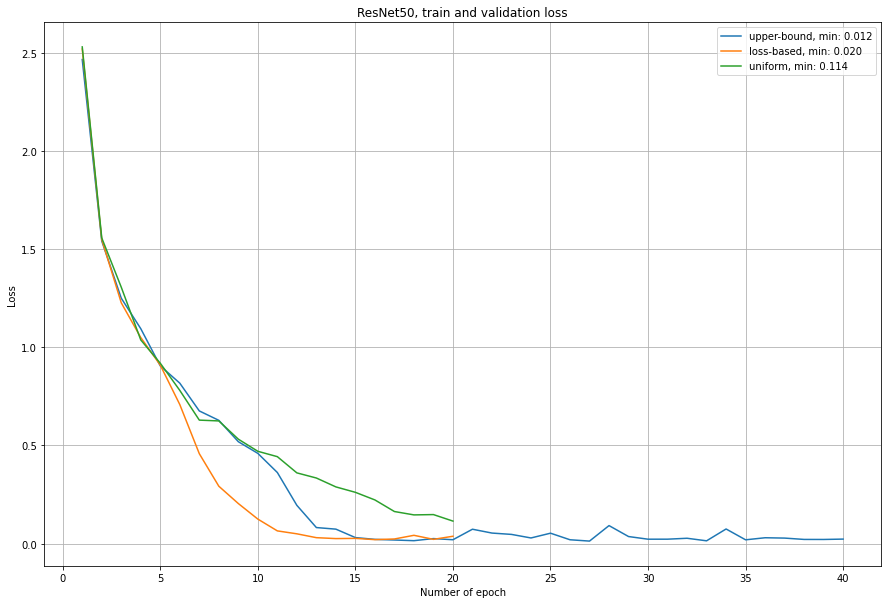

In [83]:
plt.figure(figsize=(15, 10))
plt.title('ResNet50, train and validation loss')
plt.xlabel('Number of epoch')
plt.ylabel('Loss')

epochs = np.arange(len(callback.train_loss) - 20) + 1
epochs1 = np.arange(len(callback.train_loss)) + 1
plt.plot(epochs1, callback.train_loss , label=f'upper-bound, min: {np.min(callback.train_loss):.3f}')
plt.plot(epochs, callback2.train_loss , label=f'loss-based, min: {np.min(callback2.train_loss):.3f}')
plt.plot(epochs, callback3.train_loss , label=f'uniform, min: {np.min(callback3.train_loss):.3f}')
# plt.plot(epochs, callback.train_w_loss , label='Train weighted')
# plt.plot(epochs, callback.val_loss , label=f'Validation, min: {np.min(callback.val_loss):.3f}')
plt.legend()
plt.grid(True)


In [84]:
print(f'Best loss on train: {np.min(callback.train_loss)}, on {np.argmin(callback.train_loss) + 1} epoch')
# print(f'Best weighted loss on train: {np.min(callback.train_w_loss)}, on {np.argmin(callback.train_w_loss) + 1} epoch')
print(f'Best loss on validation: {np.min(callback.val_loss)}, on {np.argmin(callback.val_loss) + 1} epoch')

Best loss on train: 0.012385510434160057, on 27 epoch
Best loss on validation: 1.06013023853302, on 13 epoch


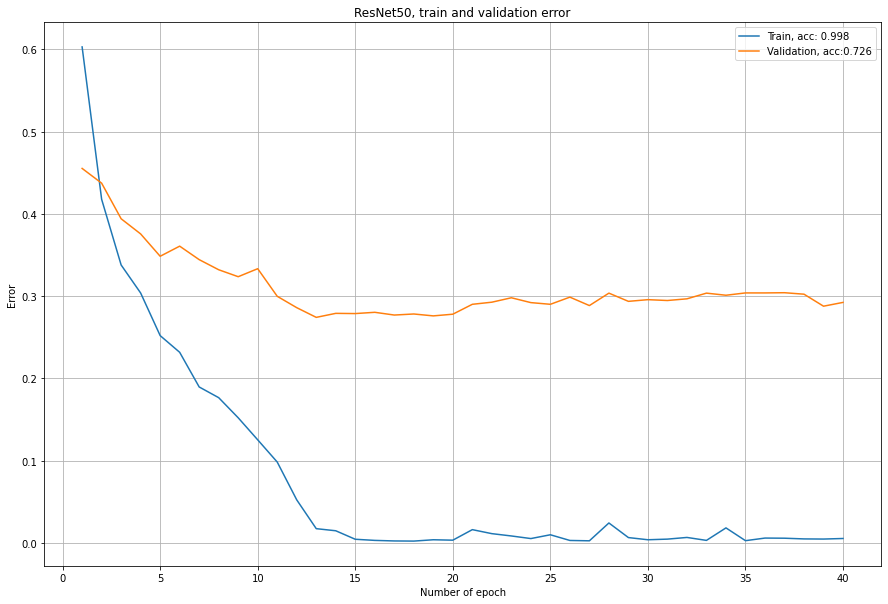

In [31]:
plt.figure(figsize=(15, 10))
plt.title('ResNet50, train and validation error')
plt.xlabel('Number of epoch')
plt.ylabel('Error')
leng1 = len(callback.train_acc)
leng2 = len(callback.val_acc)
epochs = np.arange(len(callback.train_acc)) + 1
plt.plot(epochs, np.ones(leng1) - np.array(callback.train_acc), label=f'Train, acc: {np.max(callback.train_acc):.3f}')
plt.plot(epochs, np.ones(leng2) - np.array(callback.val_acc), label=f'Validation, acc:{np.max(callback.val_acc):.3f}')
plt.legend()
plt.grid(True)

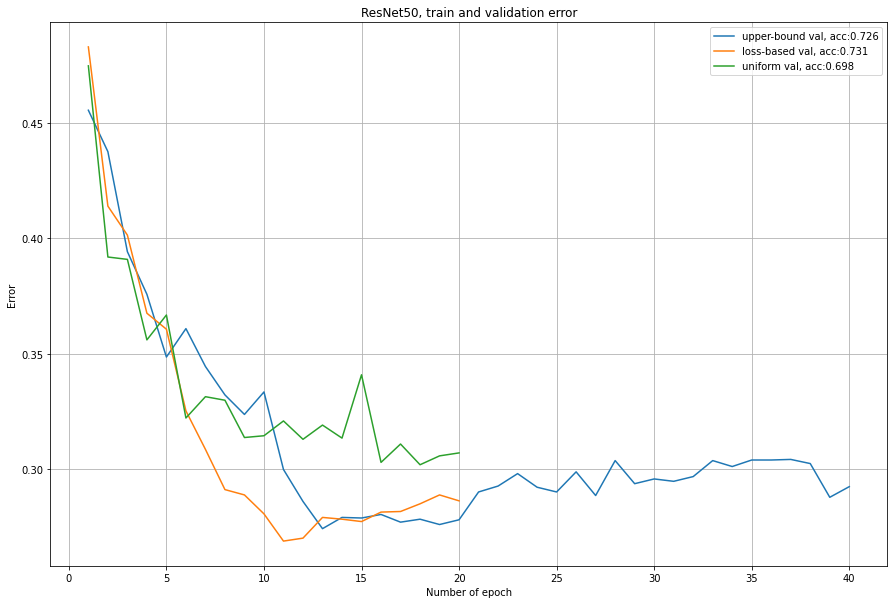

In [86]:
plt.figure(figsize=(15, 10))
plt.title('ResNet50, train and validation error')
plt.xlabel('Number of epoch')
plt.ylabel('Error')
leng1 = len(callback2.train_acc)
leng2 = len(callback.val_acc)
epochs = np.arange(len(callback.train_acc)) + 1
epochs1 = np.arange(len(callback2.train_acc)) + 1
plt.plot(epochs, np.ones(leng2) - np.array(callback.val_acc), label=f'upper-bound val, acc:{np.max(callback.val_acc):.3f}')
plt.plot(epochs1, np.ones(leng1) - np.array(callback2.val_acc), label=f'loss-based val, acc:{np.max(callback2.val_acc):.3f}')
plt.plot(epochs1, np.ones(leng1) - np.array(callback3.val_acc), label=f'uniform val, acc:{np.max(callback3.val_acc):.3f}')
plt.legend()
plt.grid(True)

In [15]:
print(f'Best accuracy on train: {np.max(callback.train_acc)}, on {np.argmax(callback.train_acc) + 1} epoch')
print(f'Best accuracy on validation: {np.max(callback.val_acc)}, on {np.argmax(callback.val_acc) + 1} epoch')

Best accuracy on train: 0.9976952624839949, on 18 epoch
Best accuracy on validation: 0.7257362355953906, on 13 epoch
